In [1]:
# these are the Classes used from the Shapely library
# - https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import LinearRing

# these are the different cap styles for the "buffer" function
from shapely.geometry import CAP_STYLE, JOIN_STYLE

# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os

In [2]:
# helper function to plot a Shapley Polygon object
def plot_poly(polygon):
    plt.plot(*polygon.exterior.xy)
    
    for i in polygon.interiors:
        plt.plot(*i.xy)

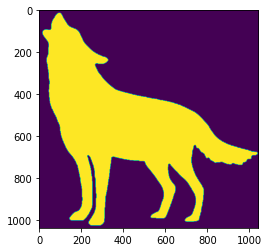

In [3]:
# initialization code - use this to change the image being processed

folder = "files" # this is the folder where the image files live

image = cv2.imread(os.path.join(folder,'wolf.png'),0)
plt.imshow(image)

image = image[::1,:]

filename = "wolf.gcode"

# TODO I might want to change this to work relative to the desired output size
# ~ right now it is relative to the image size, so smaller images need smaller numbers
line_dis = 10 # mm



In [4]:
# this returns all of the contours and heirarchy information
#  - returns a list of tuples --> (list of points, heirarchy)
def generate_border_lines(image):

    contours,heirarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)  

    contour_list = []

    for contour,heirarchy in zip(contours, heirarchy[0]):
        point_list = []
        for point in contour:
            point_list.append(tuple(point[0]))
            
        contour_list.append((point_list, heirarchy))

    return contour_list

In [5]:
# get all of the children of the parent contour
# this is used to find the "holes" in the contour 
# the cv2.RETR_CCOMP property in "generate_border_lines" sets the children as the holes in the parent
def get_children(contour_list, parent_contour):

    child_list = []

    first_child_index = parent_contour[1][2]
    child = contour_list[first_child_index]
    child_list.append(child[0])


    # loop while there are more children
    while not child[1][0] == -1:
        next_child_index = child[1][0]
        child = contour_list[next_child_index]
        child_list.append(child[0])
    
    # return the list of children
    return child_list

In [6]:
# combine the contours into Shapely Polygons
# this uses the "get_children" function to find the holes in the Polygon
def create_contour_families(contour_list):

    family_list = []

    # find the first parent contour
    for contour in contour_list:
        
        # start with a parent contour
        if contour[1][3]==-1:

            # if there are no children, create an empty family with only the parent contour
            if contour[1][2] == -1:
                child_list = []
            # otherwise, find all of the children
            else:
                child_list = get_children(contour_list, contour)

            if len(contour[0]) > 2:
                family_list.append(Polygon(contour[0], holes=child_list))

    return family_list

In [7]:
# recursively run the distance transform on the input polygon
# - if result is empty, terminate with empty list
# - if result is Polygon, add current Polygon
# - if result is MultiPolygon, run for each Polygon in the MultiPolygon
def distance_transform(polygon, distance):
        
    t = polygon.buffer(distance, cap_style = CAP_STYLE.flat, join_style = JOIN_STYLE.mitre)
    
    # if t is empty, return the empty list
    if not t:
        return []
        
    result = []

    if t.type == "MultiPolygon":
        for p in t:
            result.append([p])
            result[-1].extend(distance_transform(p, distance))
    else:
        result.append(t)
        result.extend(distance_transform(t, distance))
        
        
    return result


In [8]:
# calculate the endpoint of the spiral on the contour
# this is where the contour is rerouted to the next spiral
# - find intersections with circle around the start point
# - find the "farthest" projection distance ~ this is the intersection farthest around the curve
def calculate_end(contour, start, radius):
    
        int_buff = start.buffer(distance).exterior                    
        
        # get the intersection points
        int_points = int_buff.intersection(contour)

        max_dis = 0
        point = None
        
        if int_points.is_empty:
            return None
        elif int_points.type == "Point":
            return int_points
        else:            
            # find the farthest projected point
            for p in int_points:
                dis = contour.project(p)
                if dis > max_dis:
                    max_dis = dis
                    point = p

            return point
        
# calculate the closest point to the start
def calculate_start(contour, start, radius):
    
    
        p1,p2 = cut(contour, contour.project(start))
    
        int_buff = start.buffer(distance).exterior                    
        
        # get the intersection points
        int_points = int_buff.intersection(contour)

        min_dis = contour.length
        point = None
        
        if int_points.is_empty:
            return None
        elif int_points.type == "Point":            
            return int_points
        else:            
            # find the closest projected point
            for p in int_points:
                dis = contour.project(p)
                                
                if dis < min_dis:
                    max_dis = dis
                    point = p

            return point

In [9]:
def cycle(contour, point):
    
    # find the point projection on the contour
    proj = contour.project(point)
    
    # cut the contour at the projection distance
    result = cut(contour, proj)
    
    if len(result) == 1:
        points = result[0]
    else:
        [ls1,ls2] = result
        points = list(ls2.coords) + list(ls1.coords)

    return LineString(points)
    

In [10]:
# currently this is the best spiral algorithm, but it is not perfect
# - this finds the closest point to the next start point
# - if there is no next start point (center of spiral) it uses the distance input
def spiral_path(contour_family, distance):

    points = []

    if not contour_family:
        return points
    
    # set the start contour
    contour = contour_family[0].exterior
    
    # set the starting point as p0 (arbitrary)
    start = Point(contour.coords[0])
    
    # calculate the end point from the farthest intersection of the circle around the start point
    end = calculate_end(contour, start, distance)
    
    if end is None:
        return []
    
    ls, _ = cut(contour, contour.project(end))                

    points.extend(ls.coords)
    
    # loop through each "inner" contour
    for poly in contour_family[1:]:
        
        contour = poly.exterior
        
        # get the start point as the projection of the previous endpoint
        start = contour.interpolate(contour.project(end))
        
        # cycle the points so the start is p0
        contour = cycle(contour, start)
        
        # calculate the end point
        end = calculate_end(contour, start, distance)
        
        # if there is an endpoint, cut at the end point and preserve the first part
        if not end is None:
            ls, _ = cut(contour, contour.project(end)) 
            points.extend(ls.coords)
        
    return points

In [11]:
# this is copied code from Shapely :)
# this cuts a LineString into two at a distance
# - this is used for the "combine_paths" function to combine the fermat paths
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]
    # this is between the last point
    # this is to catch for linear rings (last point projection is 0)
    cp = line.interpolate(distance)
    return [
        LineString(coords[:-1] + [(cp.x, cp.y)]),
        LineString([(cp.x, cp.y)] + [coords[-1]])]


In [12]:
# plot a single path
def plot_path(path, color=None):
    
    X = []
    Y = []
    
    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


# recursively plot all paths in the total path
def plot_recursive_path(total_path, color=None):
    rest = []
    
    for path in total_path:
        
        if type(path) is list:
            plot_path(path, color)
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [13]:
# returns a point past the end of the line
# - this is used for the "combine_paths" function
# - there is probably a better method for this
def extend_line(p1, p2, distance):
        
    dx = p2.x-p1.x
    dy = p2.y-p1.y
    
    angle = np.arctan2(dy,dx)

    px = p2.x+(np.cos(angle)*distance)
    py = p2.y+(np.sin(angle)*distance)
    
    return Point(px, py)

In [15]:
# create a spiral path
def fermat_path(contours, distance,debug=False):
    
    path = spiral_path(contours, distance)
    
    if path:
        fermat = convert_fermat(path, distance,debug)
    else:
        fermat = path
    
    return fermat

In [168]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    root = fermat_path(contour_family, distance,debug=False)

    # combine the root and the branches
    if root:
        return combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        return branches

In [67]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    results = spiral_path(contour_family, distance)
    #results = spiral_path(contour_family, distance)
    total_path.append(results)

    return total_path

In [50]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance ,fnc):
    
    total_path = []
    
    # create the polygons from the image
    contours = generate_border_lines(image)
    polygons = create_contour_families(contours)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        # simplify the polygon to remove excess points - this helps with processing
        polygon = polygon.simplify(distance/2)
        
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
    
    return total_path

In [163]:
def calculate_break(path, start, distance):

    dis = 0
    
    while dis <= distance:
        _,path = cut(path,distance)
        
        dis = path.project(start)
    
    return path.interpolate(dis)
    

def point_distance(p1,p2):
    return np.sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)
    

def get_inner_point(path, reroute, distance):
    
    _, spiral = cut(path, distance)

    # while the projection is the end of the spiral, return
    while spiral.project(reroute) == 0:
        _, spiral = cut(spiral, distance)

    point = spiral.interpolate(spiral.project(reroute))
    
    return point
    
    
def center_inner(center, p2, distance):
    # reroute is the end of the spiral
    reroute = Point(p2.coords[0])

    # cut the center away from the next start
    end = calculate_end(center, Point(p2.coords[0]), distance)

    center, _ = cut(center, center.project(end))

    return center
    

# get the point a distance "upstream" of the point on the path
# - this is not a projection distance, but a straightline distance
def calculate_reroute(path, point, radius):
    
    buff = point.buffer(radius).exterior
    path,_ = cut(path, path.project(point))
    
    result = path.intersection(buff)
    
    if result.type == "Point":
        return result
    else:    
        return sorted(list(result), key = path.project)[-1]
    
    
# convert the spiral into the fermat spiral
def convert_fermat(path, distance,debug=False):
    
    if path:
            
        path = LineString(path)
        
        og_path = path
        
        start = Point(path.coords[0])
        end = calculate_break(path, start, distance)
        
        spiral = []
        sp1 = []
        sp2 = []
        
        # start the inner loop
        while path.project(end) != path.length:
            
            # get the reroute point away from the end
            reroute = calculate_reroute(path, end, distance)

            # cut the path at the reroute point
            p1,center = cut(path, path.project(reroute))
            
            # complete the reroute of the path at the end point
            center,p2 = cut(center, center.project(end))
            
            # get the inner point
            # - this is the point that is a distance farther than the projection distance
            start = get_inner_point(p2, reroute, distance)
            
                
            if debug:
                plt.scatter(reroute.x, reroute.y, c='cyan')
                plt.scatter(start.x, start.y, c='green')

                plot_path(p2.coords,color='orange')
                plot_path(p1.coords, color='blue')
    
            # add these coordinates to the spirals
            spiral.extend(list(p1.coords))
            
            # if the length of the remaining path is where the next jump would be, break the loop
            if p2.length == p2.project(start):    
                print("P2 EXIT")
                spiral.extend(list(p2.coords)[::-1])
                break
            
            # cut the inner contour at this point
            outer, inner = cut(p2, p2.project(start))
            sp1.append(inner)
            sp2.append(outer)
            
            # set the path to the inner part of the spiral
            path = inner
            end = calculate_break(path, start, distance)
            
            if debug:
                plt.scatter(end.x, end.y, c='red')
                plt.show()
            
            print(path.project(end) != path.length)
        else:
            print("ELSE")
            spiral.extend(list(path.coords))
            reroute = end
        
        if debug:
            plt.show()


            plot_path(spiral, color='blue')        
            for ls in sp2:
                plot_path(ls.coords, color='red')
            plt.show()

        spiral_reverse = []
        
        if sp2:
                        
            sp2 = sp2[::-1]

            # get the projection from reroute
            d = sp2[0].project(reroute)
            #d = sp2[0].length

            # loop through the contour pieces from the center
            for index, ls in enumerate(sp2[:-1]):

                # cut the point here
                if d > 0 and d < ls.length:
                    p1,_ = cut(ls, d)
                else:
                    p1 = ls

                # find the next reroute point from the start of the inner line
                d = sp2[index+1].project(Point(p1.coords[0]))

                spiral_reverse.extend(list(p1.coords)[::-1])

            ls = sp2[-1]  
            
            if debug:
                cut_pt  = ls.interpolate(d)
                plt.scatter(cut_pt.x,cut_pt.y, c='yellow')
                plt.scatter(reroute.x,reroute.y, c='magenta')
                plot_path(ls.coords)
            
            # cut the point here
            if d > 0 and d < ls.length:
                p1,_ = cut(ls, d)
            else:
                p1 = ls

            # add the last loop
            spiral_reverse.extend(list(p1.coords)[::-1])

        return spiral + spiral_reverse #, spiral, spiral_reverse, sp1,sp2
    
    else:
        return [] #,[],[],[],[]


True
False
ELSE


<IPython.core.display.Javascript object>


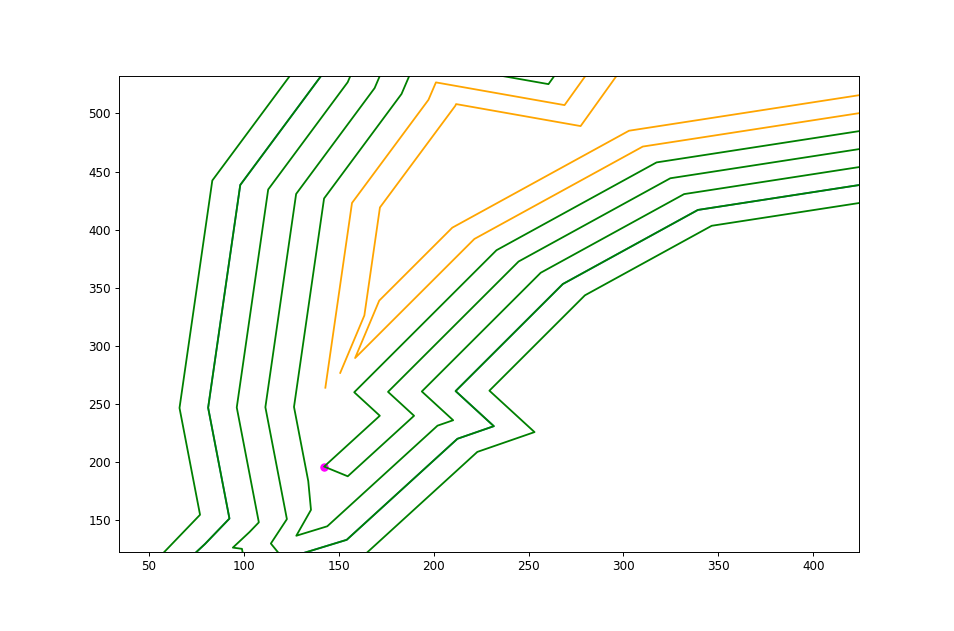

P2 EXIT


In [191]:
%matplotlib notebook
distance = 15

image = cv2.imread(os.path.join(folder,'wolf.png'),0)

path = execute(image, distance, generate_total_path)

# f_paths = []

test = convert_fermat(path[4], distance, debug=False)

test2 = convert_fermat(path[3], distance, debug=False)
# plot_path(test, color='blue')


result = combine_paths(test, [test2], distance)

plot_path(test, color='green')

plot_path(test2, color='orange')


0
ELSE


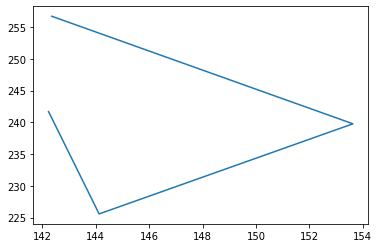

1
P2 EXIT


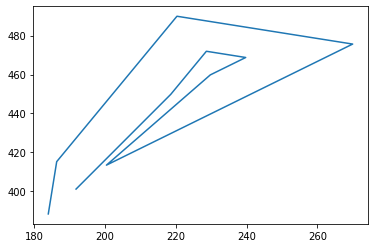

2
P2 EXIT


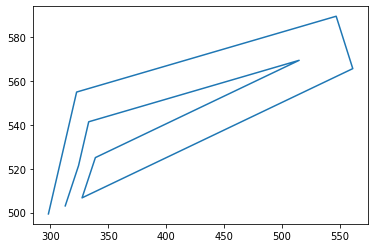

3
P2 EXIT


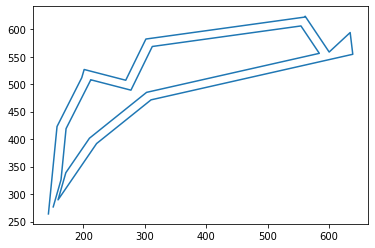

4
True
False
ELSE


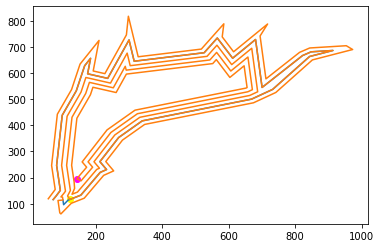

5


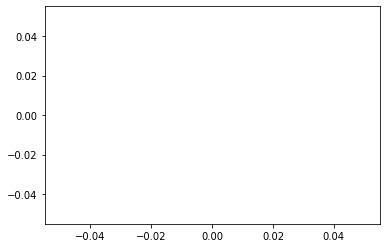

6


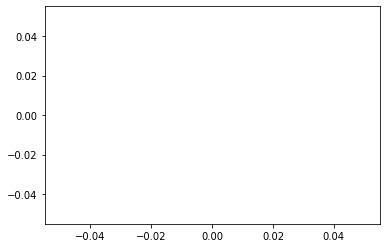

7
ELSE


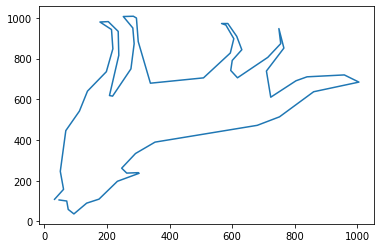

8
ELSE


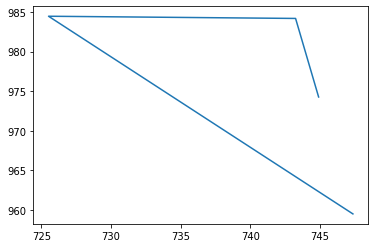

9


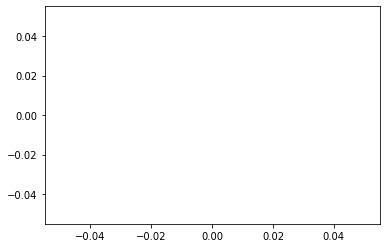

In [187]:
%matplotlib inline

for i, p in enumerate(path):
    print(i)
    plot_path(convert_fermat(p, distance))
    plt.show()

True
True
False
ELSE
True
True
False
ELSE
True
False
ELSE


<IPython.core.display.Javascript object>


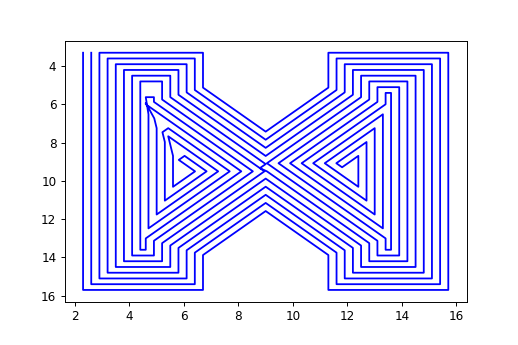

In [201]:
# Use this cell for testing - it generates the fermat spirals separate and combined and plots
# - you can use this to see the difference / errors with combinations
# path1 = create the separate path with fermat spirals
# path2 = create the combined path with fermat spirals
#%matplotlib notebook
%matplotlib inline

distance = 0.3

image = cv2.imread(os.path.join(folder,'area_test.png'),0)

path = execute(image, distance, generate_fermat_path)

# f_paths = []
# for p in path:
#     f_paths.append(convert_fermat(p, distance))
    

%matplotlib notebook
# plt.show()

plot_recursive_path(path, color='blue')
plt.gca().invert_yaxis()
plt.show()

In [149]:
plot_path(path[7], color='green')


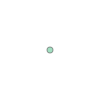

In [127]:
ls = LineString([(0,0), (5,0)])

buff = Point(ls.coords[0]).buffer(1).exterior

ls.intersection(buff)

In [53]:
%matplotlib inline

fpath = []

print(len(path))
test = path[9]

print(len(test))

p = convert_fermat(test, distance)

%matplotlib notebook
plot_path(test, color='red')
plot_recursive_path(p, color='green')

10
182


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:

for p1, p2 in zip(sp1, sp2):
    plot_path(p1.coords)
#    plot_path(p2.coords)
plt.show()

In [ ]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [ ]:
# plot all of the contours in the result from distance transform
def plot_contours(result):
    for p in result:
    
        if type(p) is list:

            plot_contours(p)

        else:
            plot_poly(p)


In [ ]:
# GCODE generation
# - this is used for converting the path into GCODE for the drawbot
# - applies an offset to each XY coordinate to avoid triggering the home flags repeatedly

x_offset = 2
y_offset = 2

# move the drawbot to a point
def command_move(p):
    return "G01 X" + str(p[0]+x_offset) + " Y" + str(p[1]+y_offset) + ";\n"

# move the pen up (drawbot specific)
def command_up():
    return "G01 Z0.5;\n"

# move the pen down (drawbot specific)
def command_down():
    return "G01 Z8.0;\n"

In [96]:
def calculate_break(path, start, distance):

    dis = 0
    
    while dis <= distance:
        _,path = cut(path,distance)
        
        dis = path.project(start)
    
    return path.interpolate(dis)
    

def point_distance(p1,p2):
    return np.sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)
    
    
    
def get_inner_point(path, reroute, distance):
    
    _, spiral = cut(path, distance)

    # while the projection is the end of the spiral, return
    while spiral.project(reroute) == 0:
        _, spiral = cut(spiral, distance)

    point = spiral.interpolate(spiral.project(reroute))
    
    return point
    
    
    
    
def center_inner(center, p2, distance):
    # reroute is the end of the spiral
    reroute = Point(p2.coords[0])


    # cut the center away from the next start
    end = calculate_end(center, Point(p2.coords[0]), distance)

    center, _ = cut(center, center.project(end))

#     plt.show()

#     plt.scatter(end.x,end.y)
#     plot_path(p1.coords)
#     plot_path(center.coords)
#     plot_path(p2.coords)
#     plt.show()

    return center
    
    
def convert_fermat(path, distance):
    
    if path:
        
        path = LineString(path)
        
        start = Point(path.coords[0])    
        
        spiral = []
        sp1 = []
        sp2 = []
        
        # start the inner loop
        while True:
            # get the first end point
            end = calculate_break(path, start, distance)

            
            print(path.length, distance)
            # get the reroute point
            reroute = calculate_start(path, end, distance)

            # cut the outer contours
            if path.project(reroute) == path.length:
                p1 = path
                spiral.extend(list(p1.coords))
            elif path.project(reroute) == 0:
                pass
            else:
                p1,_ = cut(path, path.project(reroute))
                spiral.extend(list(p1.coords))
            
            # if there is no inner contour, this will be the end of the path
            if path.project(end) == 0 or path.project(end) == path.length:
                break
            
            center,p2 = cut(path, path.project(end))

            # get the inner point
            # - this is the point that is a distance farther than the projection distance

            start = get_inner_point(p2, reroute, distance)
            
            if p2.length == p2.project(start):
                
                center = center_inner(center, p2, distance)
                
                sp2.append(p2)
                spiral.extend(center.coords)
                break
            
            # cut the inner contour at this point
            outer, inner = cut(p2, p2.project(start))
            sp1.append(inner)
            # add the outer spiral to the list
            sp2.append(outer)
            
            path = inner
        
        spiral_reverse = []
        
        
        if sp2:
            sp2 = sp2[::-1]

            # get the projection from reroute
            d = sp2[0].project(reroute)
            #d = sp2[0].length

            # loop through the contour pieces from the center
            for index, ls in enumerate(sp2[:-1]):

                # cut the point here
                if d > 0 and d < ls.length:
                    p1,_ = cut(ls, d)
                else:
                    p1 = ls

                # find the next reroute point from the start of the inner line
                d = sp2[index+1].project(Point(p1.coords[0]))

                spiral_reverse.extend(list(p1.coords)[::-1])

            ls = sp2[-1]  
            # cut the point here
            if d > 0 and d < ls.length:
                p1,_ = cut(ls, d)
            else:
                p1 = ls

            # add the last loop
            spiral_reverse.extend(list(p1.coords)[::-1])

        return spiral + spiral_reverse #, spiral, spiral_reverse, sp1,sp2
    
    else:
        return [] #,[],[],[],[]


In [ ]:
# GCODE generation
# - this takes the total path and creates a string of GCODE commands to follow the path
# - the expected input is a list of paths --> a single path should be in a list
def gcode(total_path, filename):
    
    # header function - home machine
    output = "G28 Z;\n"
    output += command_up()
    output += "G28 X Y;\n\n";
    
    for path in total_path:
        
        # move to p0
        output += command_move(path[0])
        
        # pen down
        output += command_down()
        
        # trace the path
        for p in path[1:]:
            output += command_move(p)
            
        # pen up
        output += command_up()
    
    # home machine
    output += "G28;\n"
    
    # print the number of commands
    print(len(output))
    
    # write the code to a gcode file
    f = open(filename, "w")
    f.write(output)
    f.close()
    
    # return the string (for debugging, not really needed)
    return output

In [14]:
# this combines the root and branches path
def combine_paths(root, branches, dis):
        
    root_ls = LineString(root)
        
    # find the start and end points of the root
    for b in branches:

        if not b:
            continue
        
        s1 = Point(b[0])
        e1 = Point(b[-1])
        
        s2 = Point(b[1])
        e2 = Point(b[-2])
        
        
        # extend the endpoints out of the spiral
        s3 = extend_line(s2,s1,dis*1)
        e3 = extend_line(e2,e1,dis*1)
        
        
        # compute the end point connection
        ds1 = root_ls.project(s3)
        ds2 = root_ls.project(e3)        
        
        if ds1 == 0:  # cut the root at ds2

            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = []
            ls2_list = list(root_ls.coords)[1:] # drop the first point   
        elif ds2 == 0:  # cut the root at ds2

            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = list(root_ls.coords)
            ls2_list = []
        elif ds1 == root_ls.length:
            # cut the root at ds2
            ls1, ls2 = cut(root_ls, ds1-dis)    
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds1)
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point   
        
        # if the start is the first cut
        elif ds1 < ds2:
            
            # cut the root at the start point
            ls1, ls2 = cut(root_ls, ds1)
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds2)
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point   
        else:
            # cut the root at ds2
            ls1, ls2 = cut(root_ls, ds2)    
            
            # find the end point to add to the list
            end_point = root_ls.interpolate(ds1)
        
        
            ls1_list = list(ls1.coords)
            ls2_list = list(ls2.coords)[1:] # drop the first point        
        
        if ds1 < ds2:
            new_list = ls1_list + b + [end_point] + ls2_list
        else:
            new_list = ls1_list + b[::-1] + [end_point] + ls2_list        
        
        root_ls = LineString(new_list)
        
    return list(root_ls.coords)

In [ ]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path

In [8]:
# calculate the endpoint of the spiral on the contour
# this is where the contour is rerouted to the next spiral
# - find intersections with circle around the start point
# - find the "farthest" projection distance ~ this is the intersection farthest around the curve
def calculate_end(contour, start, radius):
    
        int_buff = start.buffer(distance).exterior                    
        
        # get the intersection points
        int_points = int_buff.intersection(contour)

        max_dis = 0
        point = None
        
        if int_points.is_empty:
            return None
        elif int_points.type == "Point":
            return int_points
        else:            
            # find the farthest projected point
            for p in int_points:
                dis = contour.project(p)
                if dis > max_dis:
                    max_dis = dis
                    point = p

            return point
        
# calculate the closest point to the start
def calculate_start(contour, start, radius):
    
    
        p1,p2 = cut(contour, contour.project(start))
    
        int_buff = start.buffer(distance).exterior                    
        
        # get the intersection points
        int_points = int_buff.intersection(contour)

        min_dis = contour.length
        point = None
        
        if int_points.is_empty:
            return None
        elif int_points.type == "Point":            
            return int_points
        else:            
            # find the closest projected point
            for p in int_points:
                dis = contour.project(p)
                                
                if dis < min_dis:
                    max_dis = dis
                    point = p

            return point

In [ ]:
_ = gcode([scale_path],filename)